In [22]:
from PIL import Image
from IPython.display import Image as PIM
import matplotlib.pyplot as plt
import itertools
import skimage
import numpy as np

In [23]:
from moviepy.editor import ImageSequenceClip, AudioFileClip, VideoFileClip
from pathlib import Path

In [24]:
import cv2
import mediapipe as mp
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_face_mesh = mp.solutions.face_mesh

In [25]:
from mediapipe.python.solutions.drawing_utils import _normalized_to_pixel_coordinates

In [34]:
vid_path = '../GPEN/jtbc_output_mp4_sim/csy_lsj.mp4'

In [35]:
res = []
lips_alpha = []
inter_lips_alpha = []
#LIPS_INDEXES = list(set(itertools.chain(*mp_face_mesh.FACEMESH_LIPS)))
LIPS_INDEXES = [164, 393, 391, 322, 410, 287, 273, 335, 406, 313, 18, 83, 182, 106, 43, 57, 186, 92, 165, 167]
INTER_LIPS_INDEXES = [0, 267, 269, 270, 409, 291, 375, 321, 405, 314, 17, 84, 181, 91, 146, 61, 185, 40, 39, 37]
drawing_spec = mp_drawing.DrawingSpec(thickness=1, circle_radius=1)
cap = cv2.VideoCapture(vid_path)
with mp_face_mesh.FaceMesh(
    max_num_faces=1,
    refine_landmarks=True,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5) as face_mesh:
    idx = 0
    while cap.isOpened():
        success, image = cap.read()
        if not success:
            break
        # if idx > 35:
        #     break
        image = cv2.resize(image, (1920,1080))
        image.flags.writeable = False
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = face_mesh.process(image)

        # Draw the face mesh annotations on the image.
        image.flags.writeable = True
        #image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        
        if results.multi_face_landmarks:
            cords = []
            for face_landmarks in results.multi_face_landmarks:
                for lip_id in LIPS_INDEXES:
                    lid = face_landmarks.landmark[lip_id]
                    #cord = _normalized_to_pixel_coordinates(lid.x,lid.y,image.shape[1],image.shape[0])
                    cords.append(_normalized_to_pixel_coordinates(lid.x,lid.y,image.shape[1],image.shape[0]))
                    xs = list(zip(*cords))[0]
                    ys = list(zip(*cords))[1]
                    _len = len(xs)
                    cx = (max(xs) + min(xs)) / 2
                    cy = (max(ys) + min(ys)) / 2
                    lx = (max(xs) - min(xs)) / 2
                    ly = (max(ys) - min(ys)) / 2
                    Y, X = skimage.draw.polygon(ys, xs)
                cropped_img = np.zeros(image.shape, dtype=np.uint8)
                for i in range(len(X)):
                    cropped_img[Y[i], X[i]] = min( (max((ly - abs(cy-Y[i])), 0)/ly)*255, (max((lx - abs(cx-X[i])), 0)/lx)*255 )
                    #cropped_img[Y[i], X[i]] = np.sqrt( np.square((max((ly - abs(cy-Y[i])), 0)/ly)*255) + np.square((max((lx - abs(cx-X[i])), 0)/lx)*255) )
            lips_alpha.append(cropped_img)
            cords = []
            for face_landmarks in results.multi_face_landmarks:
                for lip_id in INTER_LIPS_INDEXES:
                    lid = face_landmarks.landmark[lip_id]
                    #cord = _normalized_to_pixel_coordinates(lid.x,lid.y,image.shape[1],image.shape[0])
                    cords.append(_normalized_to_pixel_coordinates(lid.x,lid.y,image.shape[1],image.shape[0]))
                    Y, X = skimage.draw.polygon(list(zip(*cords))[1], list(zip(*cords))[0])
                cropped_img = np.zeros(image.shape, dtype=np.uint8)
                cropped_img[Y, X] = 255 #image[Y, X]
            inter_lips_alpha.append(cropped_img)
        else:
            lips_alpha.append(np.zeros(image.shape, dtype=np.uint8))
            inter_lips_alpha.append(np.zeros(image.shape, dtype=np.uint8))
        res.append(image)
        idx += 1
            
cap.release()

In [36]:
vid_path = '../GPEN/jtbc_output_mp4_sber/csy_lsj.mp4'

In [58]:
res_over = []
cap = cv2.VideoCapture(vid_path)
while cap.isOpened():
    success, image = cap.read()
    if not success:
        break
    image.flags.writeable = False
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (res[0].shape[1], res[0].shape[0])) # yerang edit

    image.flags.writeable = True

    res_over.append(image)
            
cap.release()

In [59]:
image.shape

AttributeError: 'NoneType' object has no attribute 'shape'

In [71]:
test_idx = 35
y1,y2,x1,x2 = 200,550,1000,1250

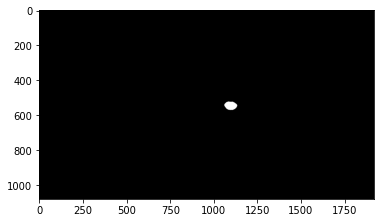

In [73]:
plt.imshow(cropped_img)#[y1:y2, x1:x2])

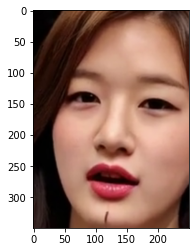

In [44]:
plt.imshow(res[test_idx][y1:y2, x1:x2])

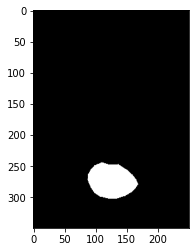

In [74]:
#plt.imshow(lips_alpha[test_idx][160:440,880:1080])
plt.imshow(inter_lips_alpha[test_idx][y1:y2, x1:x2])

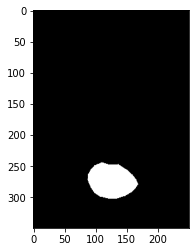

In [46]:
plt.imshow(inter_lips_alpha[test_idx][y1:y2, x1:x2])

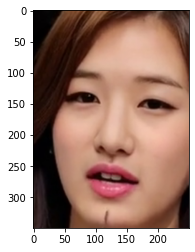

In [61]:
plt.imshow(res_over[test_idx][y1:y2, x1:x2])

In [ ]:
res[test_idx][]
plt.imshow(res_over[test_idx][y1:y2, x1:x2])

In [67]:
foreground = res_over[test_idx].astype(float)
background = res[test_idx].astype(float)
# Normalize the alpha mask to keep intensity between 0 and 1
alpha = (lips_alpha[test_idx].astype(float)/255)*1.0
foreground = cv2.multiply(alpha, foreground)
background = cv2.multiply(1.0 - alpha, background)
temp_outImage = cv2.add(foreground, background)

background = cv2.add(foreground, background)
foreground = res_over[test_idx].astype(float)
alpha = (inter_lips_alpha[test_idx].astype(float)/255)
foreground = cv2.multiply(alpha, foreground)
background = cv2.multiply(1.0 - alpha, background)
outImage = cv2.add(foreground, background)


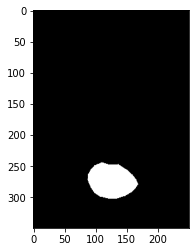

In [68]:
plt.imshow(alpha[y1:y2, x1:x2])

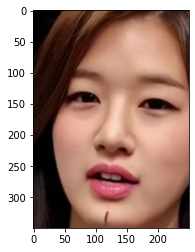

In [69]:
plt.imshow(outImage[y1:y2, x1:x2]/255)

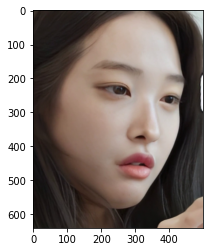

In [410]:
plt.imshow(temp_outImage[160:800,580:1080]/255)

In [465]:
blending_res = []
for idx in range(len(res)):
    foreground = res_over[idx].astype(float)
    background = res[idx].astype(float)
    # Normalize the alpha mask to keep intensity between 0 and 1
    alpha = (lips_alpha[idx].astype(float)/255) #*0.6
    foreground = cv2.multiply(alpha, foreground)
    background = cv2.multiply(1.0 - alpha, background)
    temp_outImage = cv2.add(foreground, background)

    background = cv2.add(foreground, background)
    foreground = res_over[idx].astype(float)
    alpha = (inter_lips_alpha[idx].astype(float)/255)
    foreground = cv2.multiply(alpha, foreground)
    background = cv2.multiply(1.0 - alpha, background)
    outImage = cv2.add(foreground, background)
    blending_res.append(outImage)

In [10]:
vc = VideoFileClip(vid_path)
vc.audio.write_audiofile('temp_audio.wav')

In [17]:
print(len(res))

725


In [466]:
def write_video(composed, wav_path, fps, output_path, slow_write, verbose=False):
    duration = len(composed)/fps
    
    ac = AudioFileClip(wav_path)
    if verbose:
        print(ac.duration, duration, abs(ac.duration- duration))
    #assert(abs(ac.duration - duration) < 0.1)
    print(ac.duration, duration)
    
    clip = ImageSequenceClip(composed, fps=fps)
    #clip = clip.set_audio(ac.subclip(ac.duration-duration, ac.duration))
    h, w, _ = composed[0].shape
    if h > 1920:
        clip = clip.resize((w//2, h//2))

    ffmpeg_params = None
    if slow_write:
        ffmpeg_params=['-acodec', 'aac', '-preset', 'veryslow', '-crf', '17']
        
    temp_out = output_path
    Path(temp_out).parent.mkdir(exist_ok=True)
    if verbose:
        clip.write_videofile(temp_out, ffmpeg_params=ffmpeg_params)
    else:
        clip.write_videofile(temp_out, ffmpeg_params=ffmpeg_params, verbose=verbose, logger=None)
    
    clip.close()
    ac.close()
    del clip
    del ac

In [467]:
write_video(blending_res, 'temp_audio.wav', 29.97, 'output_vid/e.mp4', slow_write=False)

25.01 24.190857524190857


In [378]:
len(res)/29.97

24.190857524190857